I wonder how easy it would be to do a basic simulation of the human vocal system, where the user manipulates the positions of the tongue / lips / vocal cords to create different sounds. My first instinct is that I might need a few more degrees before I can do this, but let's see!

Before I jump into research, I have a few ideas for how to make it work:
1. Record (or synthesize) a bunch of constant mouth noises, and interpolate between them based on mouth position. 
    - Pros:
        - No messing around with wave shapes.
        - Easy to visualize.
    - Cons:
        - May not produce very human sounds.
        - Not as cool as generating the audio from scratch.
        - *Might* not work.
    - Questions:
        - What exactly would you interpolate? My first thought is to interpolate the fft amplitudes. I'd expect that to cause two wave shapes to kind of meet in the middle.

    

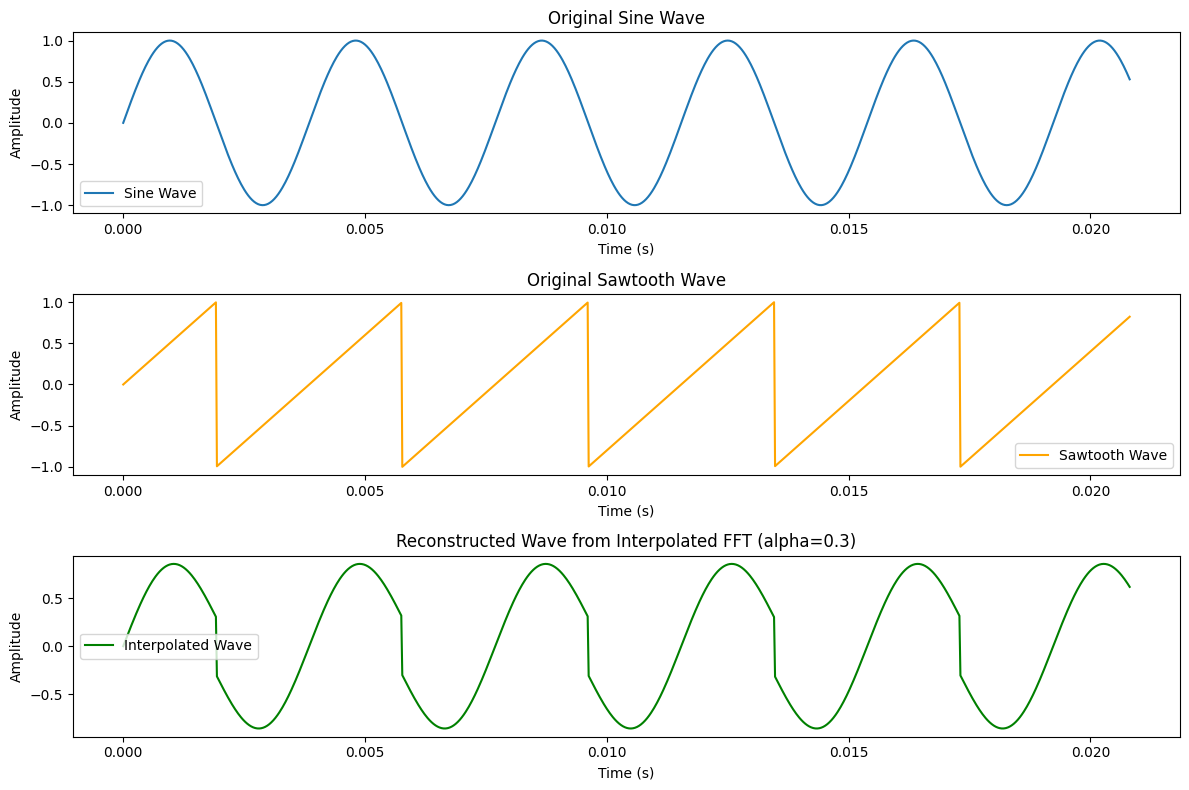

Play the Sine Wave:


Play the Sawtooth Wave:


Play the Interpolated Wave:


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.interpolate import interp1d
from IPython.display import Audio, display


def interpolate_audio(
    wave1: np.ndarray, wave2: np.ndarray, alpha: float, sample_rate: int
) -> np.ndarray:
    """
    Interpolates between two audio signals in the frequency domain based on a factor alpha.

    Parameters:
        wave1 (np.ndarray): First waveform (e.g., "aaa").
        wave2 (np.ndarray): Second waveform (e.g., "ooo").
        alpha (float): Interpolation factor; 0 returns wave1, 1 returns wave2.
        sample_rate (int): Sampling rate of the audio signals.

    Returns:
        np.ndarray: Time-domain signal of the interpolated waveform.
    """
    # Perform FFT on both waves
    fft_wave1 = fft(wave1)
    fft_wave2 = fft(wave2)
    fft_freqs = fftfreq(len(wave1), 1 / sample_rate)

    # Interpolate FFT magnitudes with adjustable alpha
    interp_func_wave1 = interp1d(
        fft_freqs, fft_wave1, kind="linear", fill_value="extrapolate"
    )
    interp_func_wave2 = interp1d(
        fft_freqs, fft_wave2, kind="linear", fill_value="extrapolate"
    )
    interpolated_fft = alpha * interp_func_wave2(fft_freqs) + (
        1 - alpha
    ) * interp_func_wave1(fft_freqs)

    # Reconstruct the interpolated signal in the time domain using the inverse FFT
    interpolated_wave = ifft(interpolated_fft).real
    return interpolated_wave


# Constants
sample_rate = 48000  # Samples per second
duration = 1.0  # Duration in seconds
freq = 260.0  # Frequency of the sine and sawtooth waves
alpha = 0.3  # Interpolation factor

# Generate sine wave and sawtooth wave
t = np.linspace(0.0, duration, int(sample_rate * duration), endpoint=False)
sine_wave = np.sin(2 * np.pi * freq * t)
sawtooth_wave = 2 * (t * freq - np.floor(1 / 2 + t * freq))

# Use interpolate_audio to blend sine and sawtooth waves
interpolated_wave = interpolate_audio(sine_wave, sawtooth_wave, alpha, sample_rate)

# Plot the original waves and the resulting interpolated wave
plt.figure(figsize=(12, 8))

# Original Sine Wave
plt.subplot(3, 1, 1)
plt.plot(t[:1000], sine_wave[:1000], label="Sine Wave")
plt.title("Original Sine Wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Original Sawtooth Wave
plt.subplot(3, 1, 2)
plt.plot(t[:1000], sawtooth_wave[:1000], label="Sawtooth Wave", color="orange")
plt.title("Original Sawtooth Wave")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Interpolated Wave (Reconstructed)
plt.subplot(3, 1, 3)
plt.plot(t[:1000], interpolated_wave[:1000], label="Interpolated Wave", color="green")
plt.title(f"Reconstructed Wave from Interpolated FFT (alpha={alpha})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

# Display audio controls
print("Play the Sine Wave:")
display(Audio(sine_wave, rate=sample_rate))

print("Play the Sawtooth Wave:")
display(Audio(sawtooth_wave, rate=sample_rate))

print("Play the Interpolated Wave:")
display(Audio(interpolated_wave, rate=sample_rate))

Wow that actually worked way better than I thought it would! I would bet, however, that the effect sort of breaks down when you use more complex tones. Well, we're already on the tangent so we might as well see it through.

In [6]:
# Assuming "aaa.wav" and "ooo.wav" are generated and available in the current directory
import soundfile as sf

# Load the "aaa" and "ooo" audio files
aaa_wave, _ = sf.read("aaa.wav", dtype="float32")
ooo_wave, _ = sf.read("ooo.wav", dtype="float32")

# Ensure both waveforms are the same length for interpolation
min_len = min(len(aaa_wave), len(ooo_wave))
aaa_wave = aaa_wave[:min_len]
ooo_wave = ooo_wave[:min_len]

for a in range(5):
    alpha = a / 5
    # Interpolate between "aaa" and "ooo" sounds
    interpolated_vocal_wave = interpolate_audio(
        aaa_wave, ooo_wave, alpha=alpha, sample_rate=sample_rate
    )
    # Play the interpolated audio
    print(f"Alpha = {alpha:.2f}:")
    display(Audio(interpolated_vocal_wave, rate=sample_rate))
print(f"Alpha = 1:")
display(Audio(ooo_wave, rate=sample_rate))

Alpha = 0.00:


Alpha = 0.20:


Alpha = 0.40:


Alpha = 0.60:


Alpha = 0.80:


Alpha = 1:


Well that didn't work! It just sounds like a chorus!

Now that I think about it though, that does make sense. Playing to sounds together just adds their waves together, and interpolating by dividing by two just halves the overall amplitude. So, the halfway point between the two sounds would just sound like both sounds at half volume.

Ok! Time for some actual research. 

After some research, I've decided to narrow my scope to a similar but much more focused idea.

The new program would take two input files, and output a new audio file, which connects the two input files by generating a third intermediary bit of audio, which interpolates between the two.

I'm still hoping to emulate some mouth sounds with this, so my test files will continue to be the "aaa" and "ooo" sounds.

The procedure would be:

1. Analyze the spectral properties of the end of input 1, and beginning of input 2, with a Short-Time Fourier Transform (STFT). 
    * Each sftp contains a **magnitude spectrum** and a **phase spectrum**
2. Interpolate the magnitude & phase spectra separately.
3. Reconstruct the generated audio with ISTFT. 

Let's give it a go.

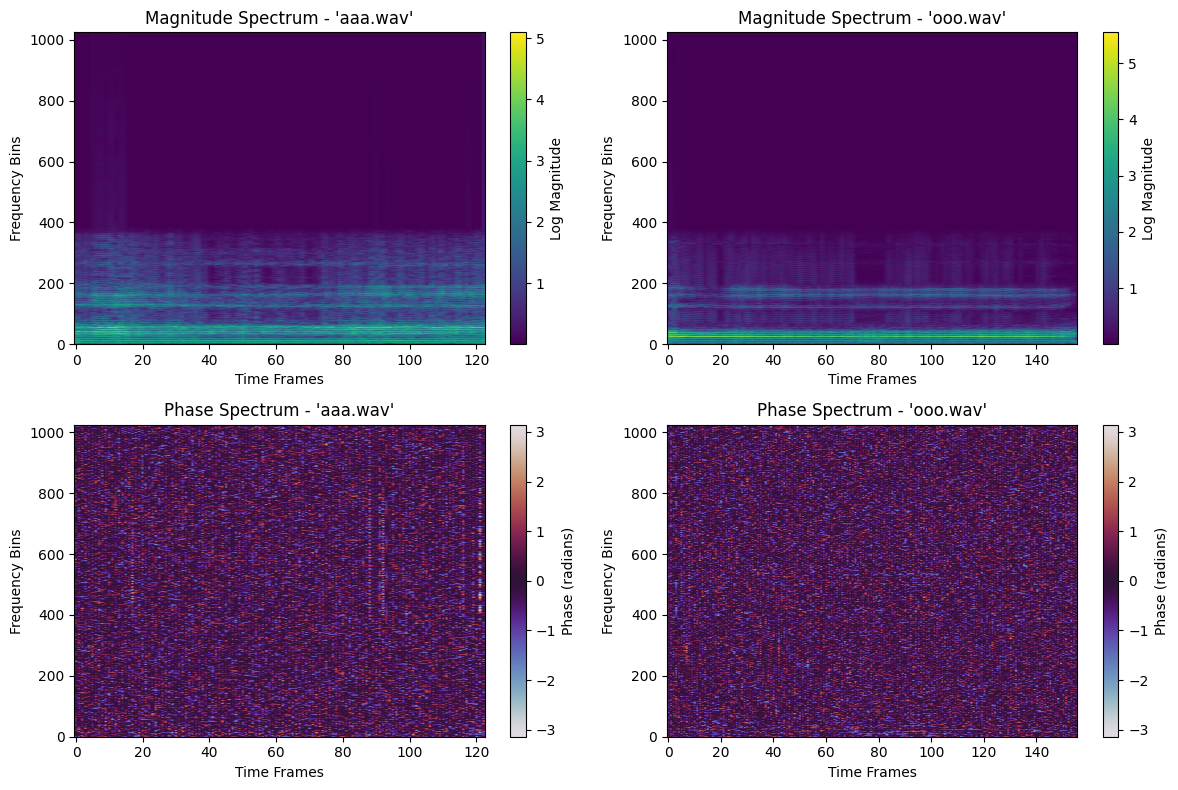

In [7]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the audio files
file1 = "aaa.wav"
file2 = "ooo.wav"

y1, sr1 = librosa.load(file1, sr=None)
y2, sr2 = librosa.load(file2, sr=None)

# Ensure the sampling rates match
if sr1 != sr2:
    raise ValueError("Sampling rates of input files must match.")

# Perform Short-Time Fourier Transform (STFT)
S1 = librosa.stft(y1)
S2 = librosa.stft(y2)

# Extract magnitude and phase
magnitude1, phase1 = np.abs(S1), np.angle(S1)
magnitude2, phase2 = np.abs(S2), np.angle(S2)

# Visualization
plt.figure(figsize=(12, 8))

# Magnitude profiles
plt.subplot(2, 2, 1)
plt.title("Magnitude Spectrum - 'aaa.wav'")
plt.imshow(np.log1p(magnitude1), aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(label="Log Magnitude")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

plt.subplot(2, 2, 2)
plt.title("Magnitude Spectrum - 'ooo.wav'")
plt.imshow(np.log1p(magnitude2), aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(label="Log Magnitude")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

# Phase profiles
plt.subplot(2, 2, 3)
plt.title("Phase Spectrum - 'aaa.wav'")
plt.imshow(phase1, aspect="auto", origin="lower", cmap="twilight")
plt.colorbar(label="Phase (radians)")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

plt.subplot(2, 2, 4)
plt.title("Phase Spectrum - 'ooo.wav'")
plt.imshow(phase2, aspect="auto", origin="lower", cmap="twilight")
plt.colorbar(label="Phase (radians)")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

plt.tight_layout()
plt.show()

Pretty! Now let's try interpolating the last second of "aaa" and the first second of "ooo".

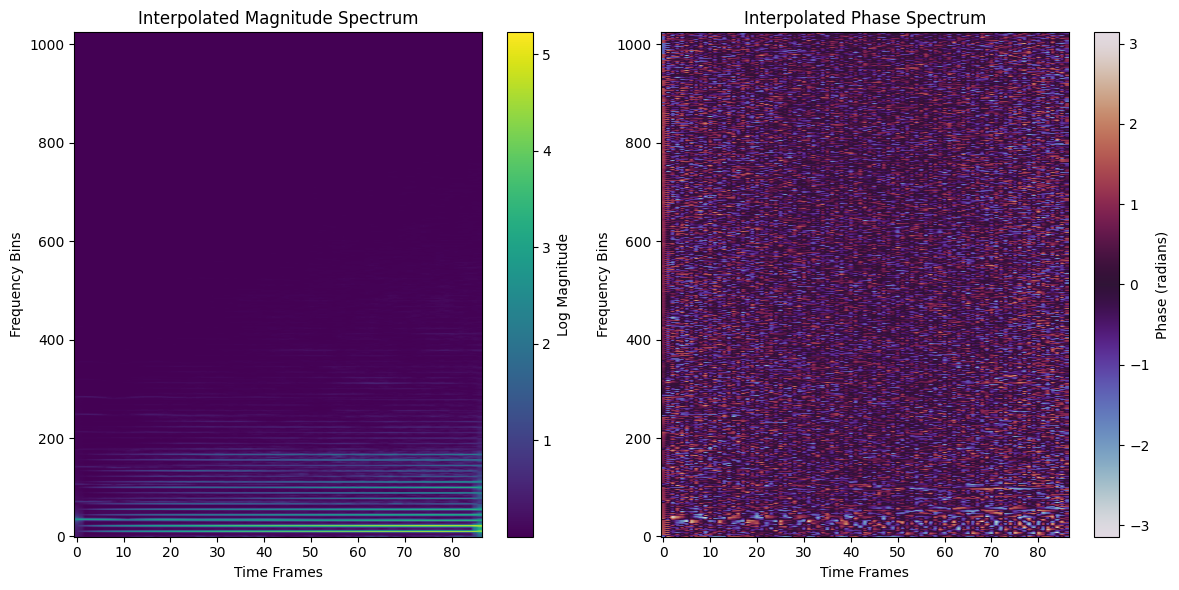

In [28]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Reload the audio files to ensure all variables are defined
file1 = "flute.wav"
file2 = "violin.wav"

y1, sr1 = librosa.load(file1, sr=None)
y2, sr2 = librosa.load(file2, sr=None)

# Define the duration for the transition in seconds
transition_duration = 1.0  # in seconds

# Calculate the number of samples corresponding to the transition duration
transition_samples = int(transition_duration * sr1)

# Extract the last 1 second from "aaa.wav" and the first 1 second from "ooo.wav"
y1_tail = y1[-transition_samples:]
y2_head = y2[:transition_samples]

# Perform STFT on these segments
S1_tail = librosa.stft(y1_tail, n_fft=2048, hop_length=512)
S2_head = librosa.stft(y2_head, n_fft=2048, hop_length=512)

# Extract magnitude and phase for both segments
magnitude1_tail, phase1_tail = np.abs(S1_tail), np.angle(S1_tail)
magnitude2_head, phase2_head = np.abs(S2_head), np.angle(S2_head)

# Ensure dimensions align for interpolation
num_freq_bins, num_time_frames = magnitude1_tail.shape
alpha = np.linspace(0, 1, num_time_frames)  # Interpolation factor
alpha = alpha[np.newaxis, :]  # Reshape to align with time axis for broadcasting

# Interpolate the magnitude and phase
magnitude_interp = (1 - alpha) * magnitude1_tail + alpha * magnitude2_head
phase_interp = (1 - alpha) * phase1_tail + alpha * phase2_head

# Combine interpolated magnitude and phase
S_interp = magnitude_interp * np.exp(1j * phase_interp)

# Visualization of the interpolated spectra
plt.figure(figsize=(12, 6))

# Interpolated Magnitude
plt.subplot(1, 2, 1)
plt.title("Interpolated Magnitude Spectrum")
plt.imshow(np.log1p(np.abs(S_interp)), aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(label="Log Magnitude")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

# Interpolated Phase
plt.subplot(1, 2, 2)
plt.title("Interpolated Phase Spectrum")
plt.imshow(np.angle(S_interp), aspect="auto", origin="lower", cmap="twilight")
plt.colorbar(label="Phase (radians)")
plt.xlabel("Time Frames")
plt.ylabel("Frequency Bins")

plt.tight_layout()
plt.show()

Looks promising! Let's see how it sounds.

In [29]:
from IPython.display import Audio

# Reconstruct the audio from the interpolated spectrum using inverse STFT
y_interp = librosa.istft(S_interp, hop_length=512)

# Play the audio directly in the notebook
Audio(data=y_interp, rate=sr1)

Wow, that actually sounds... decent! Still not perfect, but I'm pretty happy. I might need a bigger scope after all.

I think this is enough of a proof-of-concept to start the project. Off to `code/interpolator/'!